In [1]:
import pandas as pd #requires version 1.3.0
import numpy as np
import io
from sklearn.utils import shuffle
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict 
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import math
import random
from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict
import os
#!pip install venn
from venn import venn
import csv
%matplotlib inline
import graphviz
import numexpr
import itertools
from subprocess import call
from sklearn import tree
from sklearn.metrics import fbeta_score
#!pip install umap-learn
import umap.umap_ as umap
from IPython.display import display, HTML

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))


In [2]:
################################################################################
## BEGIN AA ##
################################################################################

with open('/project/gpaa/machine_learning/jainam_capstone/preprocessing/AA_labeled_batches0-16.csv', 'r') as f:
  df_labeled_init_no_liver = pd.read_csv(f)

df_labeled_init_no_liver = df_labeled_init_no_liver.rename(columns={'sample_id': "Run"})

X = df_labeled_init_no_liver.drop(['Run', 'AGE', 'white', 'black', 'hispanic', 'male', 'female', 'binary_pathology'], axis=1)

print(df_labeled_init_no_liver.shape)

(243, 13704)


<AxesSubplot:>

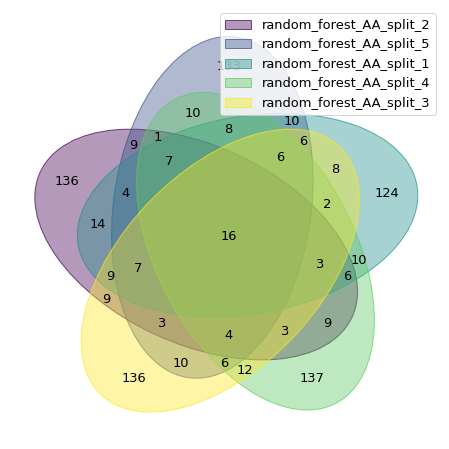

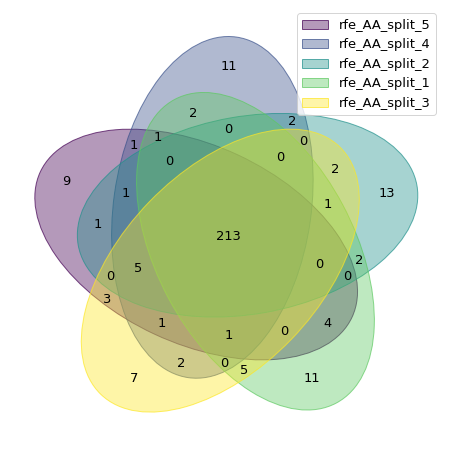

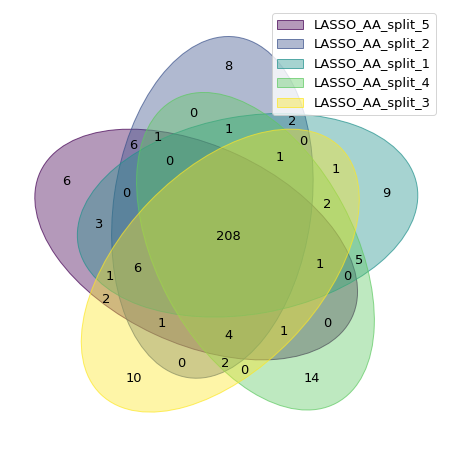

In [20]:
# make dictionaries for venn diagrams
with open('/project/gpaa/machine_learning/jainam_capstone/preprocessing/AA_labeled_batches0-16.csv', 'r') as f:
  df_labeled_init_no_liver = pd.read_csv(f)

df_labeled_init_no_liver = df_labeled_init_no_liver.rename(columns={'sample_id': "Run"})

X = df_labeled_init_no_liver.drop(['Run', 'AGE', 'white', 'black', 'hispanic', 'male', 'female', 'binary_pathology'], axis=1)

venn_dict_LASSO = {}
venn_dict_random_forest = {}
venn_dict_rfe = {}

for filename in os.listdir('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'):

  LASSO_set = set()
  random_forest_set = set()
  rfe_set = set()

  if 'ranked_indices_AA' in filename:

    if 'LASSO' in filename:

      with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None, nrows = 240)
      
        top80_list = df_top80[0].values.tolist()
        top80_list = [int(i) for i in top80_list]

        for index in top80_list:
          gene = X.columns[index]
          LASSO_set.add(gene)

        s = filename.split('_')
        venn_dict_LASSO['LASSO_AA_split_'+s[-1][0]] = LASSO_set

    elif 'random_forest' in filename:

        with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'+filename, 'r') as f:

          df_top80 = pd.read_csv(f, header=None, nrows = 240)
        
          top80_list = df_top80[0].values.tolist()
          top80_list = [int(i) for i in top80_list]

          for index in top80_list:
            gene = X.columns[index]
            random_forest_set.add(gene)

          s = filename.split('_')
          venn_dict_random_forest['random_forest_AA_split_'+s[-1][0]] = random_forest_set

    elif 'rfe' in filename:
      with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None, nrows = 240)
      
        top80_list = df_top80[0].values.tolist()
        top80_list = [int(i) for i in top80_list]

        for index in top80_list:
          gene = X.columns[index]
          rfe_set.add(gene)

        s = filename.split('_')
        venn_dict_rfe['rfe_AA_split_'+s[-1][0]] = rfe_set
        
venn(venn_dict_random_forest)
venn(venn_dict_rfe)
venn(venn_dict_LASSO)

In [4]:
# make dictionaries for generating shallow learner confidences
dict_LASSO = {}
dict_random_forest = {}
dict_rfe = {}

for filename in os.listdir('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'):

  LASSO_list = []
  random_forest_list = []
  rfe_list = []

  if 'ranked_indices_AA' in filename:

    if 'LASSO' in filename:

      with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None, nrows = 240)
      
        top80_list = df_top80[0].values.tolist()
        top80_list = [int(i) for i in top80_list]

        for index in top80_list:
          gene = X.columns[index]
          LASSO_list.append(gene)

        s = filename.split('_')
        dict_LASSO['LASSO_AA_split_'+s[-1][0]] = LASSO_list

    elif 'random_forest' in filename:

        with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'+filename, 'r') as f:

          df_top80 = pd.read_csv(f, header=None, nrows = 240)
        
          top80_list = df_top80[0].values.tolist()
          top80_list = [int(i) for i in top80_list]

          for index in top80_list:
            gene = X.columns[index]
            random_forest_list.append(gene)

          s = filename.split('_')
          dict_random_forest['random_forest_AA_split_'+s[-1][0]] = random_forest_list

    elif 'rfe' in filename:
      with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None, nrows = 240)
      
        top80_list = df_top80[0].values.tolist()
        top80_list = [int(i) for i in top80_list]

        for index in top80_list:
          gene = X.columns[index]
          rfe_list.append(gene)

        s = filename.split('_')
        dict_rfe['rfe_AA_split_'+s[-1][0]] = rfe_list

In [5]:
# from this - generate step confidences
# this section is just the individual shallow learner confidences for AA

splits = ['split_1', 'split_2', 'split_3', 'split_4', 'split_5']
sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 60, 90, 120, 150, 180, 210, 240]

with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/train_test_splits_AA_b16_new.csv', 'r') as f:
  train_test_splits = pd.read_csv(f)


target_label = df_labeled_init_no_liver['binary_pathology']
run_labels = df_labeled_init_no_liver['Run']

for split in splits:
  for filename in os.listdir('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'):
    # also check if split is in name

    if split in filename:
      cap_split = split.capitalize()

      if 'ranked_indices_AA' in filename:

        gene_list = []
        
        if 'rfe' in filename:
          filetag = 'rfe'
        if 'random_forest' in filename:
          filetag = 'random_forest'
        if 'LASSO' in filename:
          filetag = 'LASSO'

        with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'+filename, 'r') as f:
          df_top80 = pd.read_csv(f, header=None, nrows = 240)
        
          top80_list = df_top80[0].values.tolist()
          top80_list = [int(i) for i in top80_list]

          for index in top80_list:
            gene = X.columns[index]
            gene_list.append(gene)
          
        # have list of genes and file name which identifies the type of model
        # now need to size it out across step sizes

        train_col = [col for col in train_test_splits.columns if str(cap_split)+'_train' in col]
        train_indices = train_test_splits[train_col[0]].dropna().to_list()
        test_col = [col for col in train_test_splits.columns if str(cap_split)+'_test' in col]
        test_indices = train_test_splits[test_col[0]].dropna().to_list()

        for size in sizes:
          random.seed(42)
          X_temp = X[gene_list[0:size]]
          df_target = pd.DataFrame()
          df_target['Run'] = run_labels[test_indices]
          df_target['binary_pathology_true_label'] = target_label[test_indices]

          y_train, y_test = target_label[train_indices], target_label[test_indices]
          X_train, X_test = X_temp.iloc[train_indices], X_temp.iloc[test_indices]

          #NB
          NB = BernoulliNB()
          NB.fit(X_train, y_train)
          NB_probs = NB.predict_proba(X_test)
          df_target['NB_'+filetag+'_pred_0'] = NB_probs[:,0]
          df_target['NB_'+filetag+'_pred_1'] = NB_probs[:,1]


          #LR
          LR = LogisticRegressionCV(cv=5, max_iter=10000)
          LR.fit(X_train, y_train)
          LR_probs = LR.predict_proba(X_test)
          df_target['LR_'+filetag+'_pred_0'] = LR_probs[:,0]
          df_target['LR_'+filetag+'_pred_1'] = LR_probs[:,1]


          #SVM
          SM = SVC(kernel='linear', probability=True)
          SM.fit(X_train, y_train)
          SM_probs = SM.predict_proba(X_test)
          df_target['SM_'+filetag+'_pred_0'] = SM_probs[:,0]
          df_target['SM_'+filetag+'_pred_1'] = SM_probs[:,1]


          #RF
          RF = RandomForestClassifier()
          RF.fit(X_train, y_train)
          RF_probs = RF.predict_proba(X_test)
          df_target['RF_'+filetag+'_pred_0'] = RF_probs[:,0]
          df_target['RF_'+filetag+'_pred_1'] = RF_probs[:,1]


          #DT
          DT = DecisionTreeClassifier()
          DT.fit(X_train, y_train)
          DT_probs = DT.predict_proba(X_test)
          df_target['DT_'+filetag+'_pred_0'] = DT_probs[:,0]
          df_target['DT_'+filetag+'_pred_1'] = DT_probs[:,1]

          df_target.to_csv('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/'+filetag+'_AA_'+split+'_size_'+str(size)+'_confidences.csv',index=False)


In [6]:
# DE features
splits = ['split_1', 'split_2', 'split_3', 'split_4', 'split_5']
sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 60, 90, 120, 150, 180, 210, 240]

with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/train_test_splits_AA_b16_new.csv', 'r') as f:
  train_test_splits = pd.read_csv(f)

with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/average_rank_AA.csv', 'r') as f:
    genes = pd.read_csv(f)
DE_genes = genes.loc[genes['padj'] < 0.001]
DE_genes = DE_genes.loc[abs(DE_genes['log2FoldChange']) >= 1].sort_values(by = 'log2FoldChange', key = abs, ascending = False)
DE_genes = DE_genes['gene_id'].tolist()

target_label = df_labeled_init_no_liver['binary_pathology']
run_labels = df_labeled_init_no_liver['Run']

for split in splits:

  cap_split = split.capitalize()

  train_col = [col for col in train_test_splits.columns if str(cap_split)+'_train' in col]
  train_indices = train_test_splits[train_col[0]].dropna().to_list()
  test_col = [col for col in train_test_splits.columns if str(cap_split)+'_test' in col]
  test_indices = train_test_splits[test_col[0]].dropna().to_list()

  for size in sizes:
    random.seed(42)
    DE_genes_sized = DE_genes[0:size]
    #print(len(random_genes))


    X_temp = X[DE_genes_sized]
    df_target = pd.DataFrame()
    df_target['Run'] = run_labels[test_indices]
    df_target['binary_pathology_true_label'] = target_label[test_indices]

    y_train, y_test = target_label[train_indices], target_label[test_indices]
    X_train, X_test = X_temp.iloc[train_indices], X_temp.iloc[test_indices]

    #NB
    NB = BernoulliNB()
    NB.fit(X_train, y_train)
    NB_probs = NB.predict_proba(X_test)
    df_target['NB_random_pred_0'] = NB_probs[:,0]
    df_target['NB_random_pred_1'] = NB_probs[:,1]


    #LR
    LR = LogisticRegressionCV(cv=5, max_iter=10000)
    LR.fit(X_train, y_train)
    LR_probs = LR.predict_proba(X_test)
    df_target['LR_random_pred_0'] = LR_probs[:,0]
    df_target['LR_random_pred_1'] = LR_probs[:,1]


    #SVM
    SM = SVC(kernel='linear', probability=True)
    SM.fit(X_train, y_train)
    SM_probs = SM.predict_proba(X_test)
    df_target['SM_random_pred_0'] = SM_probs[:,0]
    df_target['SM_random_pred_1'] = SM_probs[:,1]


    #RF
    RF = RandomForestClassifier()
    RF.fit(X_train, y_train)
    RF_probs = RF.predict_proba(X_test)
    df_target['RF_random_pred_0'] = RF_probs[:,0]
    df_target['RF_random_pred_1'] = RF_probs[:,1]


    #DT
    DT = DecisionTreeClassifier()
    DT.fit(X_train, y_train)
    DT_probs = DT.predict_proba(X_test)
    df_target['DT_random_pred_0'] = DT_probs[:,0]
    df_target['DT_random_pred_1'] = DT_probs[:,1]

    df_target.to_csv('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/DE_AA_'+split+'_size_'+str(size)+'_confidences.csv',index=False)


In [7]:
# now the unions
splits = ['split_1', 'split_2', 'split_3', 'split_4', 'split_5']
sizes_union = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60]

with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/train_test_splits_AA_b16_new.csv', 'r') as f:
  train_test_splits = pd.read_csv(f)


target_label = df_labeled_init_no_liver['binary_pathology']
run_labels = df_labeled_init_no_liver['Run']

for split in splits:

  rfe_genes = dict_rfe['rfe_AA_'+split]
  random_forest_genes = dict_random_forest['random_forest_AA_'+split]
  LASSO_genes = dict_LASSO['LASSO_AA_'+split]

  cap_split = split.capitalize()

  train_col = [col for col in train_test_splits.columns if str(cap_split)+'_train' in col]
  train_indices = train_test_splits[train_col[0]].dropna().to_list()
  test_col = [col for col in train_test_splits.columns if str(cap_split)+'_test' in col]
  test_indices = train_test_splits[test_col[0]].dropna().to_list()

  for size in sizes_union:
    random.seed(42)
    union_genes = []
    union_genes = union_genes+rfe_genes[0:size]
    union_genes = union_genes+random_forest_genes[0:size]
    union_genes = union_genes+LASSO_genes[0:size]
    union_genes = union_genes+DE_genes[0:size]
    #print(len(union_genes))


    X_temp = X[union_genes]
    df_target = pd.DataFrame()
    df_target['Run'] = run_labels[test_indices]
    df_target['binary_pathology_true_label'] = target_label[test_indices]

    y_train, y_test = target_label[train_indices], target_label[test_indices]
    X_train, X_test = X_temp.iloc[train_indices], X_temp.iloc[test_indices]

    #NB
    NB = BernoulliNB()
    NB.fit(X_train, y_train)
    NB_probs = NB.predict_proba(X_test)
    df_target['NB_union_pred_0'] = NB_probs[:,0]
    df_target['NB_union_pred_1'] = NB_probs[:,1]


    #LR
    LR = LogisticRegressionCV(cv=5, max_iter=10000)
    LR.fit(X_train, y_train)
    LR_probs = LR.predict_proba(X_test)
    df_target['LR_union_pred_0'] = LR_probs[:,0]
    df_target['LR_union_pred_1'] = LR_probs[:,1]


    #SVM
    SM = SVC(kernel='linear', probability=True)
    SM.fit(X_train, y_train)
    SM_probs = SM.predict_proba(X_test)
    df_target['SM_union_pred_0'] = SM_probs[:,0]
    df_target['SM_union_pred_1'] = SM_probs[:,1]


    #RF
    RF = RandomForestClassifier()
    RF.fit(X_train, y_train)
    RF_probs = RF.predict_proba(X_test)
    df_target['RF_union_pred_0'] = RF_probs[:,0]
    df_target['RF_union_pred_1'] = RF_probs[:,1]


    #DT
    DT = DecisionTreeClassifier()
    DT.fit(X_train, y_train)
    DT_probs = DT.predict_proba(X_test)
    df_target['DT_union_pred_0'] = DT_probs[:,0]
    df_target['DT_union_pred_1'] = DT_probs[:,1]

    df_target.to_csv('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/union_AA_'+split+'_size_'+str(size*4)+'_confidences.csv',index=False)


In [8]:
# now random
splits = ['split_1', 'split_2', 'split_3', 'split_4', 'split_5']
sizes_random = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 60, 90, 120, 150, 180, 210, 240]

with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/train_test_splits_AA_b16_new.csv', 'r') as f:
  train_test_splits = pd.read_csv(f)


target_label = df_labeled_init_no_liver['binary_pathology']
run_labels = df_labeled_init_no_liver['Run']

for split in splits:

  cap_split = split.capitalize()

  train_col = [col for col in train_test_splits.columns if str(cap_split)+'_train' in col]
  train_indices = train_test_splits[train_col[0]].dropna().to_list()
  test_col = [col for col in train_test_splits.columns if str(cap_split)+'_test' in col]
  test_indices = train_test_splits[test_col[0]].dropna().to_list()
  
  X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
  random_indices = random.sample(range(0, len(X.columns)), 240)
  random_genes = X_train.columns[random_indices].tolist()
  for size in sizes_random:
    random.seed(42)
    random_genes_sized = random_genes[0:size]
    
    #print(len(random_genes))


    X_temp = X[random_genes_sized]
    df_target = pd.DataFrame()
    df_target['Run'] = run_labels[test_indices]
    df_target['binary_pathology_true_label'] = target_label[test_indices]

    y_train, y_test = target_label[train_indices], target_label[test_indices]
    X_train, X_test = X_temp.iloc[train_indices], X_temp.iloc[test_indices]

    #NB
    NB = BernoulliNB()
    NB.fit(X_train, y_train)
    NB_probs = NB.predict_proba(X_test)
    df_target['NB_random_pred_0'] = NB_probs[:,0]
    df_target['NB_random_pred_1'] = NB_probs[:,1]


    #LR
    LR = LogisticRegressionCV(cv=5, max_iter=10000)
    LR.fit(X_train, y_train)
    LR_probs = LR.predict_proba(X_test)
    df_target['LR_random_pred_0'] = LR_probs[:,0]
    df_target['LR_random_pred_1'] = LR_probs[:,1]


    #SVM
    SM = SVC(kernel='linear', probability=True)
    SM.fit(X_train, y_train)
    SM_probs = SM.predict_proba(X_test)
    df_target['SM_random_pred_0'] = SM_probs[:,0]
    df_target['SM_random_pred_1'] = SM_probs[:,1]


    #RF
    RF = RandomForestClassifier()
    RF.fit(X_train, y_train)
    RF_probs = RF.predict_proba(X_test)
    df_target['RF_random_pred_0'] = RF_probs[:,0]
    df_target['RF_random_pred_1'] = RF_probs[:,1]


    #DT
    DT = DecisionTreeClassifier()
    DT.fit(X_train, y_train)
    DT_probs = DT.predict_proba(X_test)
    df_target['DT_random_pred_0'] = DT_probs[:,0]
    df_target['DT_random_pred_1'] = DT_probs[:,1]

    df_target.to_csv('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/random_AA_'+split+'_size_'+str(size)+'_confidences.csv',index=False)


,4,8,12,16,20,24,28,32,36,40,80,120,160,200,240
size,,,,,,,,,,,,,,,
split_1,81.63,77.55,81.63,81.63,83.67,83.67,83.67,83.67,83.67,79.59,81.63,77.55,77.55,79.59,81.63
split_2,85.71,83.67,87.76,87.76,85.71,81.63,85.71,81.63,81.63,81.63,89.80,83.67,77.55,87.76,87.76
split_3,75.51,81.63,79.59,83.67,85.71,85.71,79.59,81.63,83.67,77.55,83.67,85.71,83.67,85.71,85.71
split_4,79.17,77.08,72.92,70.83,72.92,77.08,79.17,79.17,75.00,79.17,81.25,85.42,81.25,87.50,83.33
split_5,75.00,70.83,64.58,83.33,70.83,68.75,68.75,64.58,70.83,68.75,75.00,75.00,77.08,68.75,70.83


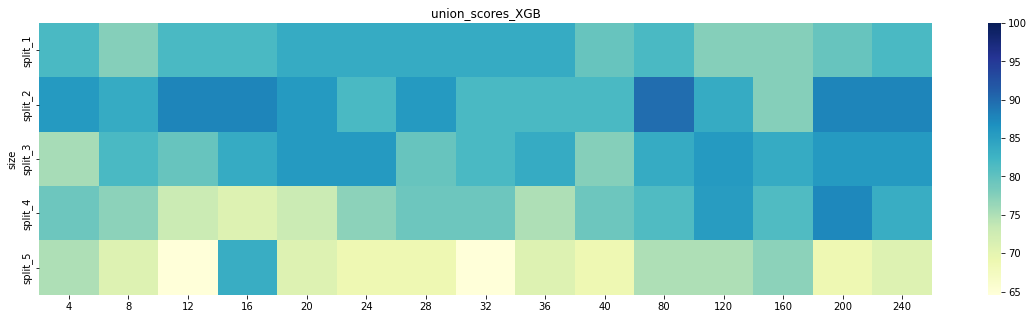

In [9]:
# now the XGBoost of the results
# starting with union
splits = ['split_1', 'split_2', 'split_3', 'split_4', 'split_5']
sizes_union = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60])
sizes = sizes_union*4
union_scores_XGB = pd.DataFrame(index=np.arange(0, 5), columns=['size']+sizes.tolist()).astype(float)

X = df_labeled_init_no_liver.drop(['AGE', 'white', 'black', 'hispanic', 'male', 'female', 'binary_pathology'], axis=1)

union_XGB_confusion_AA = []

i=0

with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/train_test_splits_AA_b16_new.csv', 'r') as f:
  train_test_splits = pd.read_csv(f)

for split in splits:

  rfe_genes = dict_rfe['rfe_AA_'+split]
  random_forest_genes = dict_random_forest['random_forest_AA_'+split]
  LASSO_genes = dict_LASSO['LASSO_AA_'+split]

  cap_split = split.capitalize()

  train_col = [col for col in train_test_splits.columns if str(cap_split)+'_train' in col]
  train_indices = train_test_splits[train_col[0]].dropna().to_list()
  test_col = [col for col in train_test_splits.columns if str(cap_split)+'_test' in col]
  test_indices = train_test_splits[test_col[0]].dropna().to_list()

  train_split = [i for i in splits if split not in i]

  scores = []

  for size in sizes_union:
    train_confidences = pd.DataFrame()
    for filename in os.listdir('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new'):
      for j in train_split:
        if j in filename:
          if 'union_AA' in filename:
            if str(size*3)+'_con' in filename:
              with open('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/'+filename, 'r') as f:
                to_append = pd.read_csv(f)
                train_confidences = train_confidences.append(to_append)

    with open('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/union_AA_'+split+'_size_'+str(size*4)+'_confidences.csv', 'r') as f:
      confidences = pd.read_csv(f)

    random.seed(42)
    union_genes = []
    union_genes = union_genes+rfe_genes[0:size]
    union_genes = union_genes+random_forest_genes[0:size]
    union_genes = union_genes+LASSO_genes[0:size]
    union_genes = union_genes+DE_genes[0:size] + ['Run']
    # drop duplicates, genes may be in common when unioning
    union_set = set(union_genes)
    union_genes = list(union_set)
    X_temp = X[union_genes]

    merged_train = pd.merge(X_temp, train_confidences, on='Run', how = 'inner')
    target_train = merged_train['binary_pathology_true_label']
    merged_train = merged_train.drop(['Run', 'binary_pathology_true_label'], axis=1)

    merged = pd.merge(X_temp, confidences, on='Run', how = 'inner')
    target = merged['binary_pathology_true_label']
    merged = merged.drop(['Run', 'binary_pathology_true_label'], axis=1)

    X_test = merged
    y_test = target
    X_train = merged_train
    y_train = target_train
    
    #print('Size: ' + str(size*3))
    #print('Test Split: ' + split)
    #print(X_test.shape)
    #print(y_test.shape)
    #print(X_train.shape)
    #print(y_train.shape)

    xgb_pathology = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, random_state=42)

    xgb_pathology.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='error',
                      verbose=False)
    
    pred = xgb_pathology.predict(X_test)
    
    acc = accuracy_score(y_test, pred)
    #acc = f1_score(y_test, pred)

    #print("Accuracy: %.2f%%" % (acc * 100.0))
    scores.append(round(acc * 100.0, 2))
    #print('Accuracy: ' + str(round(acc * 100.0, 2)))
    #print("//////////////////////////////////////////////")
    y_test_list = list(y_test)
    # want: index, and then TP/FP/TN/FN
    for j in range(len(pred)): 
        if y_test_list[j]==pred[j]==1:
           union_XGB_confusion_AA.append(('union_'+str(size*4), test_indices[j], 'TP', X['Run'][test_indices[j]]))
        if pred[j]==1 and y_test_list[j]!=pred[j]:
           union_XGB_confusion_AA.append(('union_'+str(size*4), test_indices[j], 'FP', X['Run'][test_indices[j]]))
        if y_test_list[j]==pred[j]==0:
           union_XGB_confusion_AA.append(('union_'+str(size*4), test_indices[j], 'TN', X['Run'][test_indices[j]]))
        if pred[j]==0 and y_test_list[j]!=pred[j]:
           union_XGB_confusion_AA.append(('union_'+str(size*4), test_indices[j], 'FN', X['Run'][test_indices[j]]))

  union_scores_XGB.loc[i] = [split]+scores
  i=i+1

union_scores_XGB.set_index('size', drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('union_scores_XGB')
sns.heatmap(union_scores_XGB, xticklabels=True, yticklabels=True, ax=ax, cmap="YlGnBu", vmax=100)
union_scores_XGB.head()

,3,6,9,12,15,18,21,24,27,30,60,90,120,150,180,210,240
size,,,,,,,,,,,,,,,,,
split_1,57.14,65.31,69.39,75.51,69.39,75.51,73.47,79.59,75.51,73.47,77.55,79.59,79.59,77.55,75.51,85.71,77.55
split_2,75.51,75.51,69.39,81.63,81.63,75.51,73.47,71.43,75.51,77.55,79.59,71.43,81.63,79.59,81.63,83.67,83.67
split_3,75.51,71.43,67.35,69.39,71.43,71.43,73.47,73.47,71.43,77.55,83.67,75.51,75.51,77.55,75.51,79.59,83.67
split_4,70.83,66.67,72.92,75.00,72.92,66.67,66.67,70.83,68.75,72.92,83.33,70.83,83.33,79.17,81.25,79.17,81.25
split_5,66.67,60.42,64.58,60.42,52.08,56.25,64.58,60.42,56.25,52.08,64.58,60.42,60.42,56.25,70.83,72.92,66.67


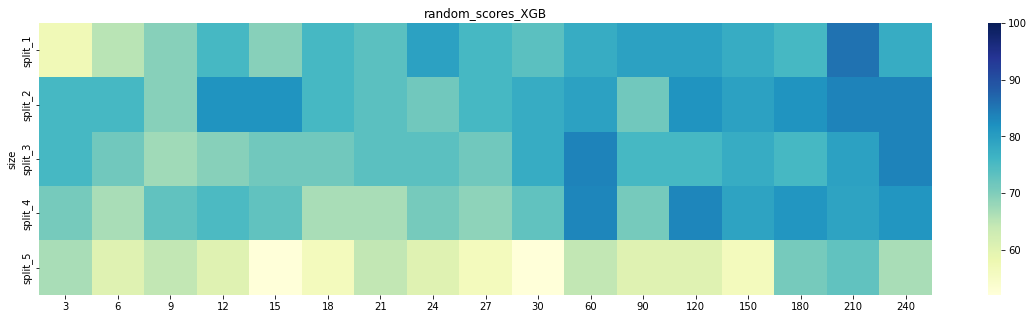

In [10]:
#XGBoost of random genes
splits = ['split_1', 'split_2', 'split_3', 'split_4', 'split_5']
sizes_random = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 60, 90, 120, 150, 180, 210, 240]
random_scores_XGB = pd.DataFrame(index=np.arange(0, 5), columns=['size']+sizes_random).astype(float)

X = df_labeled_init_no_liver.drop(['AGE', 'white', 'black', 'hispanic', 'male', 'female', 'binary_pathology'], axis=1)

random_XGB_confusion_AA = []

i=0

with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/train_test_splits_AA_b16_new.csv', 'r') as f:
  train_test_splits = pd.read_csv(f)

for split in splits:

  cap_split = split.capitalize()

  train_col = [col for col in train_test_splits.columns if str(cap_split)+'_train' in col]
  train_indices = train_test_splits[train_col[0]].dropna().to_list()
  test_col = [col for col in train_test_splits.columns if str(cap_split)+'_test' in col]
  test_indices = train_test_splits[test_col[0]].dropna().to_list()

  train_split = [i for i in splits if split not in i]
    
  X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
  random_indices = random.sample(range(0, len(X.columns)), 240)
  random_genes_split = X_train.columns[random_indices].tolist()

  scores = []

  for size in sizes_random:
    train_confidences = pd.DataFrame()
    for filename in os.listdir('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new'):
      for j in train_split:
        if j in filename:
          if 'random_AA' in filename:
            if str(size*3)+'_con' in filename:
              with open('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/'+filename, 'r') as f:
                to_append = pd.read_csv(f)
                train_confidences = train_confidences.append(to_append)

    with open('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/random_AA_'+split+'_size_'+str(size*3)+'_confidences.csv', 'r') as f:
      confidences = pd.read_csv(f)

    random.seed(42)
    random_genes = []
    random_genes = random_genes + random_genes_split[0:size] + ['Run']
    # drop duplicates, genes may be in common when randoming
    X_temp = X[random_genes]

    merged_train = pd.merge(X_temp, train_confidences, on='Run', how = 'inner')
    target_train = merged_train['binary_pathology_true_label']
    merged_train = merged_train.drop(['Run', 'binary_pathology_true_label'], axis=1)

    merged = pd.merge(X_temp, confidences, on='Run', how = 'inner')
    target = merged['binary_pathology_true_label']
    merged = merged.drop(['Run', 'binary_pathology_true_label'], axis=1)

    X_test = merged
    y_test = target
    X_train = merged_train
    y_train = target_train
    
    #print('Size: ' + str(size*3))
    #print('Test Split: ' + split)
    #print(X_test.shape)
    #print(y_test.shape)
    #print(X_train.shape)
    #print(y_train.shape)

    xgb_pathology = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, random_state=42)

    xgb_pathology.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='error',
                      verbose=False)
    
    pred = xgb_pathology.predict(X_test)
    
    acc = accuracy_score(y_test, pred)
    #acc = f1_score(y_test, pred)

    #print("Accuracy: %.2f%%" % (acc * 100.0))
    scores.append(round(acc * 100.0, 2))
    #print('Accuracy: ' + str(round(acc * 100.0, 2)))
    #print("//////////////////////////////////////////////")
    y_test_list = list(y_test)
    # want: index, and then TP/FP/TN/FN
    for j in range(len(pred)): 
        if y_test_list[j]==pred[j]==1:
           random_XGB_confusion_AA.append(('random_'+str(size*3), test_indices[j], 'TP', X['Run'][test_indices[j]]))
        if pred[j]==1 and y_test_list[j]!=pred[j]:
           random_XGB_confusion_AA.append(('random_'+str(size*3), test_indices[j], 'FP', X['Run'][test_indices[j]]))
        if y_test_list[j]==pred[j]==0:
           random_XGB_confusion_AA.append(('random_'+str(size*3), test_indices[j], 'TN', X['Run'][test_indices[j]]))
        if pred[j]==0 and y_test_list[j]!=pred[j]:
           random_XGB_confusion_AA.append(('random_'+str(size*3), test_indices[j], 'FN', X['Run'][test_indices[j]]))

  random_scores_XGB.loc[i] = [split]+scores
  i=i+1

random_scores_XGB.set_index('size', drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('random_scores_XGB')
sns.heatmap(random_scores_XGB, xticklabels=True, yticklabels=True, ax=ax, cmap="YlGnBu", vmax=100)
random_scores_XGB.head()

,3,6,9,12,15,18,21,24,27,30,60,90,120,150,180,210,240
size,,,,,,,,,,,,,,,,,
split_1,75.51,69.39,73.47,73.47,77.55,73.47,79.59,77.55,83.67,81.63,79.59,81.63,83.67,83.67,81.63,83.67,81.63
split_2,91.84,83.67,81.63,85.71,89.80,95.92,95.92,91.84,95.92,95.92,97.96,93.88,89.80,89.80,89.80,91.84,91.84
split_3,83.67,83.67,81.63,81.63,81.63,85.71,85.71,87.76,91.84,91.84,81.63,93.88,87.76,87.76,85.71,87.76,89.80
split_4,89.58,81.25,79.17,77.08,85.42,87.50,87.50,89.58,89.58,85.42,87.50,91.67,87.50,89.58,87.50,89.58,87.50
split_5,66.67,66.67,54.17,50.00,62.50,60.42,64.58,58.33,66.67,64.58,66.67,68.75,68.75,72.92,72.92,68.75,72.92


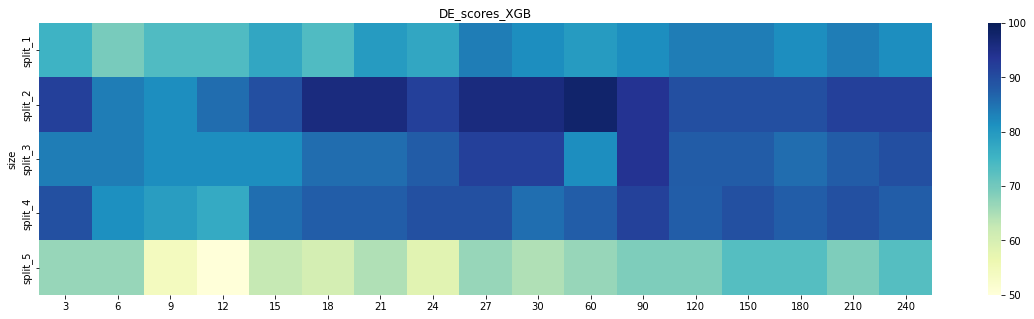

In [11]:
#XGBoost of DE Genes
splits = ['split_1', 'split_2', 'split_3', 'split_4', 'split_5']
sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 60, 90, 120, 150, 180, 210, 240]
DE_scores_XGB = pd.DataFrame(index=np.arange(0, 5), columns=['size']+sizes).astype(float)

X = df_labeled_init_no_liver.drop(['AGE', 'white', 'black', 'hispanic', 'male', 'female', 'binary_pathology'], axis=1)

DE_XGB_confusion_AA = []

i=0

with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/train_test_splits_AA_b16_new.csv', 'r') as f:
  train_test_splits = pd.read_csv(f)

for split in splits:

  cap_split = split.capitalize()

  train_col = [col for col in train_test_splits.columns if str(cap_split)+'_train' in col]
  train_indices = train_test_splits[train_col[0]].dropna().to_list()
  test_col = [col for col in train_test_splits.columns if str(cap_split)+'_test' in col]
  test_indices = train_test_splits[test_col[0]].dropna().to_list()

  train_split = [i for i in splits if split not in i]

  scores = []

  for size in sizes:
    train_confidences = pd.DataFrame()
    for filename in os.listdir('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/'):
      for j in train_split:
        if j in filename:
          if 'DE_AA' in filename:
            if str(size)+'_con' in filename:
              with open('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/'+filename, 'r') as f:
                to_append = pd.read_csv(f)
                train_confidences = train_confidences.append(to_append)

    with open('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/DE_AA_'+split+'_size_'+str(size)+'_confidences.csv', 'r') as f:
      confidences = pd.read_csv(f)

    random.seed(42)
    DE_temp = DE_genes[0:size]+ ['Run']
    X_temp = X[DE_temp]

    merged_train = pd.merge(X_temp, train_confidences, on='Run', how = 'inner')
    target_train = merged_train['binary_pathology_true_label']
    merged_train = merged_train.drop(['Run', 'binary_pathology_true_label'], axis=1)

    merged = pd.merge(X_temp, confidences, on='Run', how = 'inner')
    target = merged['binary_pathology_true_label']
    merged = merged.drop(['Run', 'binary_pathology_true_label'], axis=1)

    X_test = merged
    y_test = target
    X_train = merged_train
    y_train = target_train
    
    #print('Size: ' + str(size*3))
    #print('Test Split: ' + split)
    #print(X_test.shape)
    #print(y_test.shape)
    #print(X_train.shape)
    #print(y_train.shape)

    xgb_pathology = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, random_state=42)

    xgb_pathology.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='error',
                      verbose=False)
    
    pred = xgb_pathology.predict(X_test)
    
    acc = accuracy_score(y_test, pred)
    #acc = f1_score(y_test, pred)

    #print("Accuracy: %.2f%%" % (acc * 100.0))
    scores.append(round(acc * 100.0, 2))
    #print('Accuracy: ' + str(round(acc * 100.0, 2)))
    #print("//////////////////////////////////////////////")
    y_test_list = list(y_test)
    # want: index, and then TP/FP/TN/FN
    for j in range(len(pred)): 
        if y_test_list[j]==pred[j]==1:
           DE_XGB_confusion_AA.append(('DE_'+str(size), test_indices[j], 'TP', X['Run'][test_indices[j]]))
        if pred[j]==1 and y_test_list[j]!=pred[j]:
           DE_XGB_confusion_AA.append(('DE_'+str(size), test_indices[j], 'FP', X['Run'][test_indices[j]]))
        if y_test_list[j]==pred[j]==0:
           DE_XGB_confusion_AA.append(('DE_'+str(size), test_indices[j], 'TN', X['Run'][test_indices[j]]))
        if pred[j]==0 and y_test_list[j]!=pred[j]:
           DE_XGB_confusion_AA.append(('DE_'+str(size), test_indices[j], 'FN', X['Run'][test_indices[j]]))
    
  DE_scores_XGB.loc[i] = [split]+scores
  i=i+1

DE_scores_XGB.set_index('size', drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('DE_scores_XGB')
sns.heatmap(DE_scores_XGB, xticklabels=True, yticklabels=True, ax=ax, cmap="YlGnBu", vmax=100)
DE_scores_XGB.head()

,3,6,9,12,15,18,21,24,27,30,60,90,120,150,180,210,240
size,,,,,,,,,,,,,,,,,
split_1,79.59,79.59,77.55,77.55,77.55,77.55,77.55,79.59,77.55,77.55,81.63,81.63,83.67,81.63,81.63,81.63,83.67
split_2,81.63,83.67,87.76,87.76,87.76,87.76,79.59,79.59,79.59,83.67,81.63,81.63,83.67,79.59,79.59,81.63,81.63
split_3,81.63,77.55,79.59,83.67,83.67,89.80,87.76,81.63,83.67,87.76,87.76,91.84,89.80,89.80,87.76,87.76,85.71
split_4,72.92,68.75,77.08,75.00,75.00,79.17,79.17,79.17,79.17,81.25,83.33,79.17,77.08,79.17,77.08,77.08,79.17
split_5,70.83,66.67,66.67,62.50,70.83,72.92,68.75,70.83,75.00,70.83,64.58,68.75,72.92,72.92,72.92,72.92,70.83


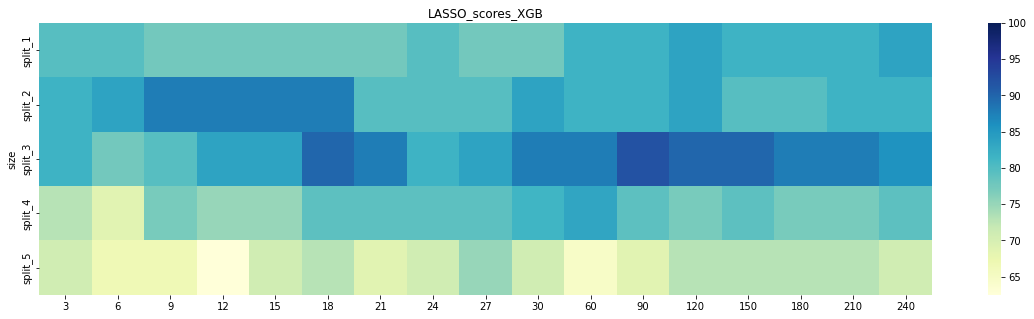

In [12]:
# now the XGBoost of the results LASSO
splits = ['split_1', 'split_2', 'split_3', 'split_4', 'split_5']
sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 60, 90, 120, 150, 180, 210, 240]
LASSO_scores_XGB = pd.DataFrame(index=np.arange(0, 5), columns=['size']+sizes).astype(float)

X = df_labeled_init_no_liver.drop(['AGE', 'white', 'black', 'hispanic', 'male', 'female', 'binary_pathology'], axis=1)

LASSO_XGB_confusion_AA = []

i=0

with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/train_test_splits_AA_b16_new.csv', 'r') as f:
  train_test_splits = pd.read_csv(f)

for split in splits:

  LASSO_genes = dict_LASSO['LASSO_AA_'+split]

  cap_split = split.capitalize()

  train_col = [col for col in train_test_splits.columns if str(cap_split)+'_train' in col]
  train_indices = train_test_splits[train_col[0]].dropna().to_list()
  test_col = [col for col in train_test_splits.columns if str(cap_split)+'_test' in col]
  test_indices = train_test_splits[test_col[0]].dropna().to_list()

  train_split = [i for i in splits if split not in i]

  scores = []

  for size in sizes:
    train_confidences = pd.DataFrame()
    for filename in os.listdir('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/'):
      for j in train_split:
        if j in filename:
          if 'LASSO_AA' in filename:
            if str(size)+'_con' in filename:
              with open('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/'+filename, 'r') as f:
                to_append = pd.read_csv(f)
                train_confidences = train_confidences.append(to_append)

    with open('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/LASSO_AA_'+split+'_size_'+str(size)+'_confidences.csv', 'r') as f:
      confidences = pd.read_csv(f)

    random.seed(42)
    LASSO_temp = LASSO_genes[0:size]+ ['Run']
    X_temp = X[LASSO_temp]

    merged_train = pd.merge(X_temp, train_confidences, on='Run', how = 'inner')
    target_train = merged_train['binary_pathology_true_label']
    merged_train = merged_train.drop(['Run', 'binary_pathology_true_label'], axis=1)

    merged = pd.merge(X_temp, confidences, on='Run', how = 'inner')
    target = merged['binary_pathology_true_label']
    merged = merged.drop(['Run', 'binary_pathology_true_label'], axis=1)

    X_test = merged
    y_test = target
    X_train = merged_train
    y_train = target_train
    
    #print('Size: ' + str(size*3))
    #print('Test Split: ' + split)
    #print(X_test.shape)
    #print(y_test.shape)
    #print(X_train.shape)
    #print(y_train.shape)

    xgb_pathology = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, random_state=42)

    xgb_pathology.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='error',
                      verbose=False)
    
    pred = xgb_pathology.predict(X_test)
    
    acc = accuracy_score(y_test, pred)
    #acc = f1_score(y_test, pred)

    #print("Accuracy: %.2f%%" % (acc * 100.0))
    scores.append(round(acc * 100.0, 2))
    #print('Accuracy: ' + str(round(acc * 100.0, 2)))
    #print("//////////////////////////////////////////////")
    y_test_list = list(y_test)
    # want: index, and then TP/FP/TN/FN
    for j in range(len(pred)): 
        if y_test_list[j]==pred[j]==1:
           LASSO_XGB_confusion_AA.append(('LASSO_'+str(size), test_indices[j], 'TP', X['Run'][test_indices[j]]))
        if pred[j]==1 and y_test_list[j]!=pred[j]:
           LASSO_XGB_confusion_AA.append(('LASSO_'+str(size), test_indices[j], 'FP', X['Run'][test_indices[j]]))
        if y_test_list[j]==pred[j]==0:
           LASSO_XGB_confusion_AA.append(('LASSO_'+str(size), test_indices[j], 'TN', X['Run'][test_indices[j]]))
        if pred[j]==0 and y_test_list[j]!=pred[j]:
           LASSO_XGB_confusion_AA.append(('LASSO_'+str(size), test_indices[j], 'FN', X['Run'][test_indices[j]]))
    
  LASSO_scores_XGB.loc[i] = [split]+scores
  i=i+1

LASSO_scores_XGB.set_index('size', drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('LASSO_scores_XGB')
sns.heatmap(LASSO_scores_XGB, xticklabels=True, yticklabels=True, ax=ax, cmap="YlGnBu", vmax=100)
LASSO_scores_XGB.head()

,3,6,9,12,15,18,21,24,27,30,60,90,120,150,180,210,240
size,,,,,,,,,,,,,,,,,
split_1,83.67,75.51,81.63,81.63,83.67,79.59,83.67,83.67,81.63,79.59,79.59,79.59,81.63,79.59,81.63,81.63,81.63
split_2,79.59,83.67,87.76,83.67,87.76,87.76,85.71,83.67,87.76,89.80,85.71,89.80,87.76,81.63,85.71,81.63,81.63
split_3,81.63,73.47,85.71,79.59,79.59,77.55,85.71,81.63,81.63,87.76,89.80,85.71,85.71,85.71,81.63,89.80,89.80
split_4,72.92,70.83,75.00,79.17,77.08,77.08,81.25,83.33,87.50,83.33,81.25,83.33,81.25,81.25,85.42,87.50,87.50
split_5,68.75,62.50,62.50,60.42,75.00,72.92,79.17,75.00,77.08,70.83,75.00,70.83,72.92,70.83,75.00,70.83,70.83


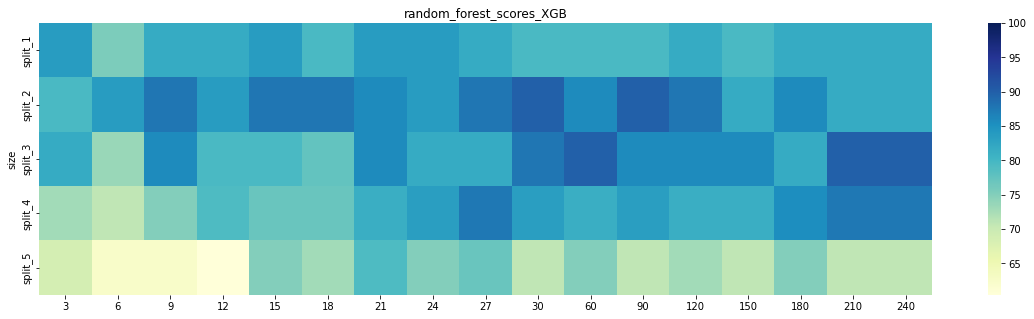

In [13]:
# now the XGBoost of the results random_forest
splits = ['split_1', 'split_2', 'split_3', 'split_4', 'split_5']
sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 60, 90, 120, 150, 180, 210, 240]
random_forest_scores_XGB = pd.DataFrame(index=np.arange(0, 5), columns=['size']+sizes).astype(float)

X = df_labeled_init_no_liver.drop(['AGE', 'white', 'black', 'hispanic', 'male', 'female', 'binary_pathology'], axis=1)

random_forest_XGB_confusion_AA = []

i=0

with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/train_test_splits_AA_b16_new.csv', 'r') as f:
  train_test_splits = pd.read_csv(f)

for split in splits:

  random_forest_genes = dict_random_forest['random_forest_AA_'+split]

  cap_split = split.capitalize()

  train_col = [col for col in train_test_splits.columns if str(cap_split)+'_train' in col]
  train_indices = train_test_splits[train_col[0]].dropna().to_list()
  test_col = [col for col in train_test_splits.columns if str(cap_split)+'_test' in col]
  test_indices = train_test_splits[test_col[0]].dropna().to_list()

  train_split = [i for i in splits if split not in i]

  scores = []

  for size in sizes:
    train_confidences = pd.DataFrame()
    for filename in os.listdir('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/'):
      for j in train_split:
        if j in filename:
          if 'random_forest_AA' in filename:
            if str(size)+'_con' in filename:
              with open('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/'+filename, 'r') as f:
                to_append = pd.read_csv(f)
                train_confidences = train_confidences.append(to_append)

    with open('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/random_forest_AA_'+split+'_size_'+str(size)+'_confidences.csv', 'r') as f:
      confidences = pd.read_csv(f)

    random.seed(42)
    random_forest_temp = random_forest_genes[0:size]+ ['Run']
    X_temp = X[random_forest_temp]

    merged_train = pd.merge(X_temp, train_confidences, on='Run', how = 'inner')
    target_train = merged_train['binary_pathology_true_label']
    merged_train = merged_train.drop(['Run', 'binary_pathology_true_label'], axis=1)

    merged = pd.merge(X_temp, confidences, on='Run', how = 'inner')
    target = merged['binary_pathology_true_label']
    merged = merged.drop(['Run', 'binary_pathology_true_label'], axis=1)

    X_test = merged
    y_test = target
    X_train = merged_train
    y_train = target_train
    
    #print('Size: ' + str(size*3))
    #print('Test Split: ' + split)
    #print(X_test.shape)
    #print(y_test.shape)
    #print(X_train.shape)
    #print(y_train.shape)

    xgb_pathology = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, random_state=42)

    xgb_pathology.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='error',
                      verbose=False)
    
    pred = xgb_pathology.predict(X_test)
    
    acc = accuracy_score(y_test, pred)
    #acc = f1_score(y_test, pred)

    #print("Accuracy: %.2f%%" % (acc * 100.0))
    scores.append(round(acc * 100.0, 2))
    #print('Accuracy: ' + str(round(acc * 100.0, 2)))
    #print("//////////////////////////////////////////////")
    y_test_list = list(y_test)
    # want: index, and then TP/FP/TN/FN
    for j in range(len(pred)): 
        if y_test_list[j]==pred[j]==1:
           random_forest_XGB_confusion_AA.append(('random_forest_'+str(size), test_indices[j], 'TP', X['Run'][test_indices[j]]))
        if pred[j]==1 and y_test_list[j]!=pred[j]:
           random_forest_XGB_confusion_AA.append(('random_forest_'+str(size), test_indices[j], 'FP', X['Run'][test_indices[j]]))
        if y_test_list[j]==pred[j]==0:
           random_forest_XGB_confusion_AA.append(('random_forest_'+str(size), test_indices[j], 'TN', X['Run'][test_indices[j]]))
        if pred[j]==0 and y_test_list[j]!=pred[j]:
           random_forest_XGB_confusion_AA.append(('random_forest_'+str(size), test_indices[j], 'FN', X['Run'][test_indices[j]]))

  random_forest_scores_XGB.loc[i] = [split]+scores
  i=i+1

random_forest_scores_XGB.set_index('size', drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('random_forest_scores_XGB')
sns.heatmap(random_forest_scores_XGB, xticklabels=True, yticklabels=True, ax=ax, cmap="YlGnBu", vmax=100)
random_forest_scores_XGB.head()

,3,6,9,12,15,18,21,24,27,30,60,90,120,150,180,210,240
size,,,,,,,,,,,,,,,,,
split_1,61.22,79.59,77.55,77.55,65.31,65.31,69.39,69.39,73.47,71.43,73.47,75.51,71.43,75.51,79.59,75.51,75.51
split_2,69.39,85.71,79.59,83.67,77.55,77.55,77.55,79.59,81.63,77.55,77.55,85.71,81.63,83.67,81.63,83.67,85.71
split_3,77.55,65.31,69.39,79.59,73.47,69.39,69.39,67.35,65.31,71.43,71.43,85.71,83.67,81.63,83.67,81.63,83.67
split_4,68.75,81.25,83.33,75.00,79.17,81.25,77.08,75.00,75.00,75.00,79.17,79.17,77.08,81.25,81.25,77.08,75.00
split_5,60.42,66.67,68.75,66.67,64.58,64.58,68.75,68.75,66.67,68.75,70.83,66.67,68.75,64.58,68.75,70.83,68.75


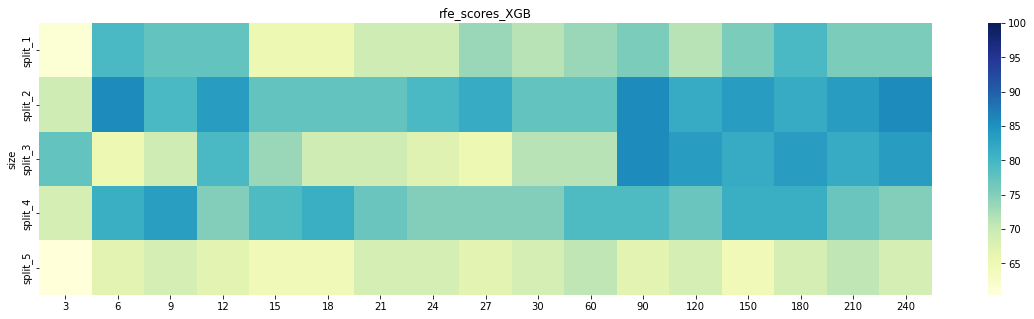

In [14]:
# now the XGBoost of the results rfe
splits = ['split_1', 'split_2', 'split_3', 'split_4', 'split_5']
sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 60, 90, 120, 150, 180, 210, 240]
rfe_scores_XGB = pd.DataFrame(index=np.arange(0, 5), columns=['size']+sizes).astype(float)

X = df_labeled_init_no_liver.drop(['AGE', 'white', 'black', 'hispanic', 'male', 'female', 'binary_pathology'], axis=1)

rfe_XGB_confusion_AA = []

i=0

with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/train_test_splits_AA_b16_new.csv', 'r') as f:
  train_test_splits = pd.read_csv(f)

for split in splits:

  rfe_genes = dict_rfe['rfe_AA_'+split]

  cap_split = split.capitalize()

  train_col = [col for col in train_test_splits.columns if str(cap_split)+'_train' in col]
  train_indices = train_test_splits[train_col[0]].dropna().to_list()
  test_col = [col for col in train_test_splits.columns if str(cap_split)+'_test' in col]
  test_indices = train_test_splits[test_col[0]].dropna().to_list()

  train_split = [i for i in splits if split not in i]

  scores = []

  for size in sizes:
    train_confidences = pd.DataFrame()
    for filename in os.listdir('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/'):
      for j in train_split:
        if j in filename:
          if 'rfe_AA' in filename:
            if str(size)+'_con' in filename:
              with open('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/'+filename, 'r') as f:
                to_append = pd.read_csv(f)
                train_confidences = train_confidences.append(to_append)

    with open('/project/gpaa/machine_learning/jainam_capstone/holdout_feature_step_confidences_new/rfe_AA_'+split+'_size_'+str(size)+'_confidences.csv', 'r') as f:
      confidences = pd.read_csv(f)

    random.seed(42)
    rfe_temp = rfe_genes[0:size]+ ['Run']
    X_temp = X[rfe_temp]

    merged_train = pd.merge(X_temp, train_confidences, on='Run', how = 'inner')
    target_train = merged_train['binary_pathology_true_label']
    merged_train = merged_train.drop(['Run', 'binary_pathology_true_label'], axis=1)

    merged = pd.merge(X_temp, confidences, on='Run', how = 'inner')
    target = merged['binary_pathology_true_label']
    merged = merged.drop(['Run', 'binary_pathology_true_label'], axis=1)

    X_test = merged
    y_test = target
    X_train = merged_train
    y_train = target_train
    
    #print('Size: ' + str(size*3))
    #print('Test Split: ' + split)
    #print(X_test.shape)
    #print(y_test.shape)
    #print(X_train.shape)
    #print(y_train.shape)

    xgb_pathology = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, random_state=42)

    xgb_pathology.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='error',
                      verbose=False)
    
    pred = xgb_pathology.predict(X_test)
    
    acc = accuracy_score(y_test, pred)
    #acc = f1_score(y_test, pred)

    #print("Accuracy: %.2f%%" % (acc * 100.0))
    scores.append(round(acc * 100.0, 2))
    #print('Accuracy: ' + str(round(acc * 100.0, 2)))
    #print("//////////////////////////////////////////////")
    y_test_list = list(y_test)
    # want: index, and then TP/FP/TN/FN
    for j in range(len(pred)): 
        if y_test_list[j]==pred[j]==1:
           rfe_XGB_confusion_AA.append(('rfe_'+str(size), test_indices[j], 'TP', X['Run'][test_indices[j]]))
        if pred[j]==1 and y_test_list[j]!=pred[j]:
           rfe_XGB_confusion_AA.append(('rfe_'+str(size), test_indices[j], 'FP', X['Run'][test_indices[j]]))
        if y_test_list[j]==pred[j]==0:
           rfe_XGB_confusion_AA.append(('rfe_'+str(size), test_indices[j], 'TN', X['Run'][test_indices[j]]))
        if pred[j]==0 and y_test_list[j]!=pred[j]:
           rfe_XGB_confusion_AA.append(('rfe_'+str(size), test_indices[j], 'FN', X['Run'][test_indices[j]]))

  rfe_scores_XGB.loc[i] = [split]+scores
  i=i+1

rfe_scores_XGB.set_index('size', drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('rfe_scores_XGB')
sns.heatmap(rfe_scores_XGB, xticklabels=True, yticklabels=True, ax=ax, cmap="YlGnBu", vmax=100)
rfe_scores_XGB.head()

In [15]:
df = pd.DataFrame(union_XGB_confusion_AA, columns =['model_id', 'index', 'confusion_mat', 'sample_id'])
df.to_csv('/project/gpaa/machine_learning/jainam_capstone/confusion_matrix_new/holdout_union_XGB_confusion_AA.csv')

df = pd.DataFrame(DE_XGB_confusion_AA, columns =['model_id', 'index', 'confusion_mat', 'sample_id'])
df.to_csv('/project/gpaa/machine_learning/jainam_capstone/confusion_matrix_new/holdout_DE_XGB_confusion_AA.csv')

df = pd.DataFrame(random_forest_XGB_confusion_AA, columns =['model_id', 'index', 'confusion_mat', 'sample_id'])
df.to_csv('/project/gpaa/machine_learning/jainam_capstone/confusion_matrix_new/holdout_random_forest_XGB_confusion_AA.csv')

df = pd.DataFrame(rfe_XGB_confusion_AA, columns =['model_id', 'index', 'confusion_mat', 'sample_id'])
df.to_csv('/project/gpaa/machine_learning/jainam_capstone/confusion_matrix_new/holdout_RFE_XGB_confusion_AA.csv')

df = pd.DataFrame(LASSO_XGB_confusion_AA, columns =['model_id', 'index', 'confusion_mat', 'sample_id'])
df.to_csv('/project/gpaa/machine_learning/jainam_capstone/confusion_matrix_new/holdout_LASSO_XGB_confusion_AA.csv')


In [16]:
average_scores = pd.concat([LASSO_scores_XGB.mean(),
                           random_forest_scores_XGB.mean(),
                           rfe_scores_XGB.mean(),
                            DE_scores_XGB.mean(),
                           random_scores_XGB.mean()], axis = 1, ignore_index=True).transpose()
error_scores = pd.concat([LASSO_scores_XGB.std(),
                           random_forest_scores_XGB.std(),
                           rfe_scores_XGB.std(),
                          DE_scores_XGB.std(),
                           random_scores_XGB.std()], axis = 1, ignore_index=True).transpose()

In [17]:
methods = ['LASSO', 'Random Forest', 'RFE','Differentially Expressed Genes (p < 0.001)', 'Random Genes', ]

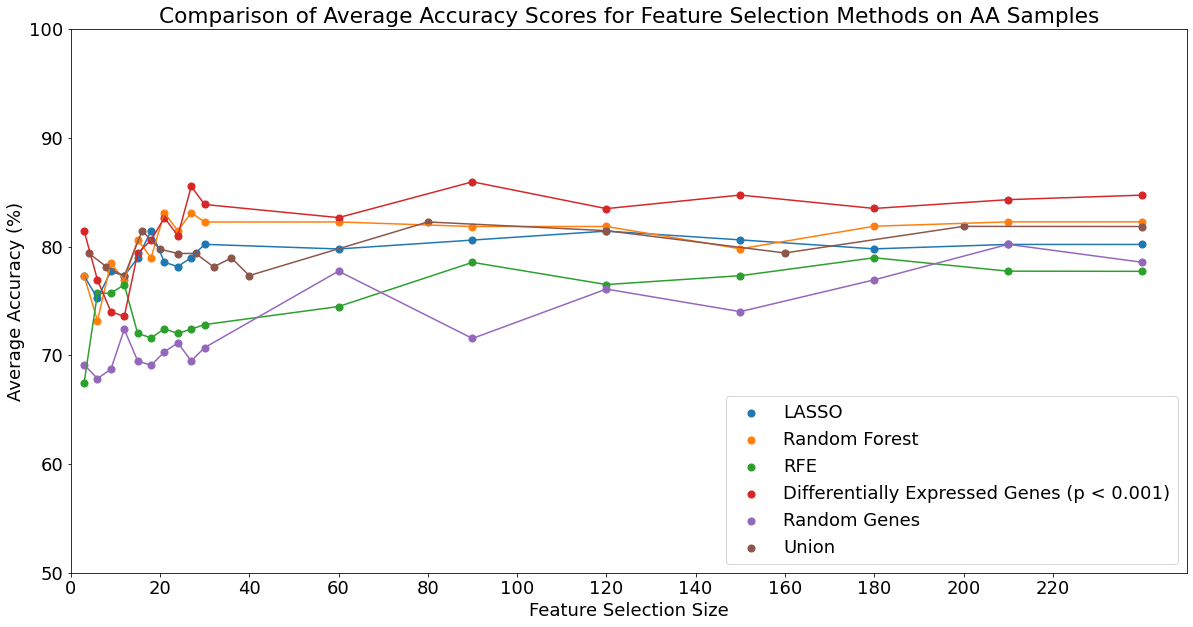

In [19]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Comparison of Average Accuracy Scores for Feature Selection Methods on AA Samples')
for k in range(0, len(methods)):
    ax.scatter([int(i) for i in average_scores.columns], average_scores.loc[k], label = methods[k], s = 50)
    ax.plot([int(i) for i in average_scores.columns], average_scores.loc[k])
    #ax.errorbar([int(i) for i in average_scores.columns], average_scores.loc[k], yerr = error_scores.loc[k], capsize = 10)
ax.scatter([int(i) for i in union_scores_XGB.columns], union_scores_XGB.mean(), label = 'Union', s = 50)
ax.plot([int(i) for i in union_scores_XGB.columns], union_scores_XGB.mean())
plt.legend(loc = "lower right")
plt.ylim([50, 100])
plt.xlim([0, 250])
plt.xticks(np.arange(0, 240, 20))
plt.rcParams.update({'font.size': 20})
plt.ylabel("Average Accuracy (%)")
plt.xlabel("Feature Selection Size")
plt.show()